<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/DL_Assignment_3_Arjun_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting Up the Notebook
This section involves the importing of important librabries,setting wandb,checking for GPU and mounting onto the drive.

In [1]:
#import all the libraries that would be used in this notebook
import csv
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM,Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 8.0MB/s 
     |████████████████████████████████| 133kB 56.4MB/s 
     |████████████████████████████████| 174kB 43.6MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# to mount to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading Data and Preprocessing 

In [ ]:
#make sure to upload the Dakshina Dataset in your drive and name the folder as Dakshina_Dataset
dakshina_dataset_hindi = '/content/drive/MyDrive/Dakshina_Dataset/hi/lexicons'

In [ ]:
#all the dataset paths
dev_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.dev.tsv")
train_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.train.tsv")
test_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.test.tsv")

In [ ]:
#function to load the dataset from the dataset path
def load_dataset(path,test_dataset = False):
    dataset = open(path)
    read_dataset = csv.reader(dataset,delimiter = '\t')
    x = []
    y = []
    for row in read_dataset:
        x.append(row[1])
        if test_dataset:
            y.append(row[0])
        else:
            y.append("\t"+row[0]+'\n')

    return np.array(x),np.array(y)


In [ ]:
x_raw_train,y_raw_train = load_dataset(train_dataset_path,False)
x_raw_val,y_raw_val = load_dataset(dev_dataset_path,True)
x_raw_test,y_raw_test = load_dataset(test_dataset_path,True)

In [ ]:
english_alphabets = 'abcdefghijklmnopqrstuvwxyz'
english_alpha2index = {"PAD": 0}
for index,alpha in enumerate(english_alphabets):
    english_alpha2index[alpha] = index + 1

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabets.append('\t')
hindi_alphabets.append('\n')

hindi_alpha2index = {"PAD" : 0}
for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index + 1

english_index2alpha = {0: "PAD"}
hindi_index2alpha = {0: "PAD"}


for index,alpha in enumerate(english_alphabets):
    english_index2alpha[index + 1] = alpha

for index,alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[index + 1] = alpha


In [ ]:
def get_integer_encode(word,alpha2index,max_length = 25):
    integer_encode = np.zeros((max_length,),dtype='int')
    for index,alpha in enumerate(word):
        integer_encode[index] = alpha2index[alpha]
    return integer_encode

def get_word_decode(integer_encoded,index2alpha):
    
    word = ""
    for integer in integer_encoded:
        word += index2alpha[integer]
    return word


def encode_docs(docs,alpha2index,max_length = 25):
    encoded_docs = np.zeros((docs.shape[0],max_length),dtype='int')
    for index,word in enumerate(docs):
        encoded_docs[index] = get_integer_encode(word,alpha2index)
    return encoded_docs



In [ ]:
integer_encoded_x_train = encode_docs(x_raw_train,english_alpha2index)
integer_encoded_y_train = encode_docs(y_raw_train,hindi_alpha2index)

In [ ]:
decoder_input_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")
decoder_output_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")

for i,integer_encoded_data in enumerate(integer_encoded_y_train):
    for t,integer in enumerate(integer_encoded_data):
        decoder_input_data[i, t, integer]= 1.0
        if t > 0:
            decoder_output_data[i, t - 1, integer] = 1.0

In [ ]:
integer_encoded_x_val = encode_docs(x_raw_val,english_alpha2index)
integer_encoded_y_val = encode_docs(y_raw_val,hindi_alpha2index)

In [ ]:
decoder_input_val = np.zeros((integer_encoded_y_val.shape[0],25,len(hindi_alpha2index)),dtype="float32")
decoder_output_val = np.zeros((integer_encoded_y_val.shape[0],25,len(hindi_alpha2index)),dtype="float32")

for i,integer_encoded_data in enumerate(integer_encoded_y_val):
    for t,integer in enumerate(integer_encoded_data):
        decoder_input_val[i, t, integer]= 1.0
        if t > 0:
            decoder_output_val[i, t - 1, integer] = 1.0

# The Generic RNN Class

In [ ]:
class RNN():

    def __init__(self,embedding_size,num_encoder_layers,num_decoder_layers,hidden_layer_size,cell_type,drop_out_ratio,in_char_size,out_char_size,input_len = 25):

        self.embedding_size = embedding_size
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.hidden_layer_size = hidden_layer_size
        self.cell_type = cell_type
        self.drop_out_ratio = drop_out_ratio
        self.in_char_size = in_char_size
        self.out_char_size = out_char_size
        self.input_len = input_len

        self._build_rnn_network()

    def _build_rnn_network(self):

        # Embedding 
        embedding_inputs = keras.Input(shape=(None,))
        embedding_layer = Embedding(self.in_char_size, self.embedding_size , input_length=self.input_len)
        encoder_inputs = embedding_layer(embedding_inputs)

        #Encoder

        self.encoder_layers = []
        for _ in range(self.num_encoder_layers-1):
            encoder_layer = getattr(layers,self.cell_type)(self.hidden_layer_size, dropout=self.drop_out_ratio, return_sequences=True)
            encoder_inputs = encoder_layer(encoder_inputs)
            self.encoder_layers.append(encoder_layer)

        last_encoder_layer = getattr(layers,self.cell_type)(self.hidden_layer_size, dropout=self.drop_out_ratio, return_state=True)
        encoder_outputs,*encoder_states = last_encoder_layer(encoder_inputs)
        self.encoder_layers.append(last_encoder_layer)

        #Decoder
        initial_decoder_inputs = keras.Input(shape=(None, self.out_char_size))
        decoder_inputs = initial_decoder_inputs

        self.decoder_layers = []

        for _ in range(self.num_decoder_layers):

            decoder_layer = getattr(layers,self.cell_type)(self.hidden_layer_size, dropout=self.drop_out_ratio, return_sequences=True,return_state=True)
            decoder_inputs,*decoder_states = decoder_layer(decoder_inputs,initial_state=encoder_states)
            self.decoder_layers.append(decoder_layer)

        decoder_outputs = decoder_inputs
        decoder_dense = Dense(self.out_char_size, activation="softmax")
        decoder_outputs = decoder_dense(decoder_outputs)

        model = keras.Model([embedding_inputs, initial_decoder_inputs], decoder_outputs) 

        self.model = model
        self.embedding_inputs = embedding_inputs
        self.encoder_states = encoder_states
        self.decoder_inputs = initial_decoder_inputs
        self.decoder_dense = decoder_dense

    def compile(self,optimizer="rmsprop"):

        self.model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )

    def fit(self,encoder_input,decoder_input,decoder_output,batch_size = 64,epochs = 5):
        self.model.fit(
        [encoder_input, decoder_input],
        decoder_output,
        batch_size=batch_size,
        epochs=epochs,
        # callbacks = [wandb.keras.WandbCallback()],
        validation_split=0.1
        )

    def build_inference_model(self):

        self.encoder_model = Model(self.embedding_inputs,self.encoder_states)

        decoder_state_input = []
        for i in range(len(self.encoder_states)) :
            new_state = keras.Input(shape=(self.hidden_layer_size,))
            decoder_state_input.append(new_state)

        initial_decoder_inputs = self.decoder_inputs

        decoder_inputs = initial_decoder_inputs
        for layer in self.decoder_layers :
            decoder_inputs, *decoder_states = layer(decoder_inputs,initial_state=decoder_state_input)

        decoder_outputs = decoder_inputs
        decoder_outputs = self.decoder_dense(decoder_outputs)

        self.decoder_model = Model(
            [initial_decoder_inputs] + decoder_state_input,
            [decoder_outputs] + decoder_states
            )


    def _decode_sequence(self,word):

        input_seq = get_integer_encode(word,english_alpha2index)
        input_seq = input_seq.reshape(1,25)
    
        states_value = self.encoder_model.predict(input_seq)

        target_seq = np.zeros((1,1, len(hindi_alpha2index)))
        target_seq[0,0, hindi_alpha2index["\t"]] = 1.0

        decoded_word = ""
        while True:
            output_tokens, *states = self.decoder_model.predict([target_seq] + [states_value])

            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            sampled_char = hindi_index2alpha[sampled_token_index]
        
            if sampled_char == "\n" or len(decoded_word) > 25:
                break

            decoded_word += sampled_char

            target_seq = np.zeros((1, 1,len(hindi_alpha2index)))
            target_seq[0, 0, sampled_token_index] = 1.0

            states_value = [states[i] for i in range(len(states))]

        return decoded_word

    def evaluate(self,X_test,Y_test):
        correct = 0
        for english_word,hindi_word in zip(X_test,Y_test):
            predicted_hindi_word = self._decode_sequence(english_word)
            if predicted_hindi_word == hindi_word:
                correct += 1

        acc = (correct/X_test.shape[0])*100
        return acc


#A Sample Run of the Model

In [ ]:
hyperparameters = {
    "embedding_size" : 125,
    "num_encoder_layers" : 1,
    "num_decoder_layers" : 1,
    "hidden_layer_size" : 256,
    "cell_type" : "LSTM",
    "drop_out_ratio": 0.4,
    "in_char_size": len(english_alpha2index),
    "out_char_size": len(hindi_alpha2index),
    "input_len": 25,
    }

net = RNN(**hyperparameters)


In [ ]:
net.compile()
net.fit(integer_encoded_x_train, decoder_input_data,decoder_output_data,epochs = 25)

Epoch 1/25
691/691 [==============================] - 11s 12ms/step - loss: 1.1295 - accuracy: 0.7370 - val_loss: 0.7722 - val_accuracy: 0.7994
Epoch 2/25
691/691 [==============================] - 7s 11ms/step - loss: 0.7803 - accuracy: 0.7937 - val_loss: 0.6081 - val_accuracy: 0.8323
Epoch 3/25
691/691 [==============================] - 7s 11ms/step - loss: 0.6390 - accuracy: 0.8254 - val_loss: 0.4880 - val_accuracy: 0.8647
Epoch 4/25
691/691 [==============================] - 7s 11ms/step - loss: 0.5085 - accuracy: 0.8580 - val_loss: 0.3742 - val_accuracy: 0.8920
Epoch 5/25
691/691 [==============================] - 7s 11ms/step - loss: 0.4062 - accuracy: 0.8827 - val_loss: 0.3133 - val_accuracy: 0.9123
Epoch 6/25
691/691 [==============================] - 7s 11ms/step - loss: 0.3325 - accuracy: 0.9019 - val_loss: 0.2567 - val_accuracy: 0.9251
Epoch 7/25
691/691 [==============================] - 7s 10ms/step - loss: 0.2808 - accuracy: 0.9162 - val_loss: 0.2282 - val_accuracy: 0.932

In [ ]:
net.build_inference_model()

In [ ]:
net.evaluate(x_raw_val,y_raw_val)

patila  पतीला  पतिला
nakum  नकुम  नाकुम
punaravalokan  पुनरावलोकन  पुनरावलों
rajkaran  राजकरण  राजकरण
hitake  हाईटेक  हितके
shyamdas  श्यामदास  श्यामद्स
rasna  रसना  रसन्ना
celina  सेलीना  सेलिना
cricketeron  क्रिकेटरों  क्रिक्टरों
orlando  ओरलैंडो  ऑर्लेंडो
gangabai  गंगाबाई  गंगाबाई
thanks  थैंक्स  ठंक्स
najar  नजर  नज़र
duptta  दुपट्टा  दुप्ता
darvaajaa  दरवाजा  दरवाजा
typhoon  टाइफून  तिप्ण
marte  मारते  मारते
interpol  इंटरपोल  इंटरपोल
chhedte  छेड़ते  छेड़ते
sampradayikata  सांप्रदायिकता  संप्रदायिकता
hansda  हंसदा  हंसदा
kavval  कव्वाल  काववाल
mansikta  मानसिकता  मानीसिकता
dhanarthi  धनार्थी  धनरती
riyon  रियान  रियों
kanton  कांटों  कंतों
gomatinagar  गोमतीनगर  गोमेटनगर
startup  स्टार्टअप  स्टार्टप
bali  बली  बली
jockey  जॉकी  जॉकी
sampradayik  सांप्रदायिक  संप्रदायिक
ncg  एससीजी  एनएीजी
chitthiyon  चिठ्ठियों  चित्तियों
dhoondhte  ढूंढते  ढूंडते
profesion  प्रोफेशन  प्रोफ़ीशन
vipreet  विपरीत  विप्रेत
indy  इंडी  इंडी
baikunth  बैकुंठ  बेनुंता
deghat  देघाट  देघात
judge  जज  जुड

26.8

#Sweep configuration and Sweep Results

In [ ]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'word_acc',
        'goal' : 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [64,128,96]
        },
        'num_encoder_layers': {
            'values': [1,2,3]
        },
        'num_decoder_layers': {
            'values': [1,2,3]
        },
        'hidden_layer_size': {
            'values': [64,128,256]
        },
        'cell_type' : {
            'values': ['LSTM','GRU','SimpleRNN']  
        },
        
        'drop_out_ratio': {
            'values': [0,0.2,0.4]
        },
        'batch_size': {
            'values': [64]
        },
        'epochs': {
            'values': [25]
        },
        'optimizer':{
            'values': ['adam','rmsprop']
        }
        
    }
}

In [ ]:
def train():

    defaults = dict(
    embedding_size = 64,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    hidden_layer_size = 128,
    cell_type = "LSTM",
    drop_out_ratio = 0,
    batch_size = 64,
    epochs = 10,
    optimizer = 'rmsprop',
    )

    wandb.init(project="CS6910-Assignment3",config = defaults)
    config = wandb.config

    hyperparameters = {
    "embedding_size" : config.embedding_size,
    "num_encoder_layers" : config.num_encoder_layers,
    "num_decoder_layers" : config.num_decoder_layers,
    "hidden_layer_size" : config.hidden_layer_size,
    "cell_type" : config.cell_type,
    "drop_out_ratio": config.drop_out_ratio,
    "in_char_size": len(english_alpha2index),
    "out_char_size": len(hindi_alpha2index),
    "input_len": 25,
    }

    net = RNN(**hyperparameters)
    net.compile(optimizer = config.optimizer)
    net.fit(integer_encoded_x_train, decoder_input_data,decoder_output_data,batch_size = config.batch_size,epochs = config.epochs)


    net.build_inference_model()
    combined_validation_data = list(zip(x_raw_val,y_raw_val))
    np.random.shuffle(combined_validation_data)
    (x_val,y_val) = zip(*combined_validation_data)
    x_val_100,y_val_100 = np.array(x_val[:100]),np.array(y_val[:100])

    word_accuracy = net.evaluate(x_val_100,y_val_100)
    wandb.log({"word_acc": word_accuracy})



In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="theindianwriter", project="CS6910-Assignment3")

Create sweep with ID: nk5cbn8i
Sweep URL: https://wandb.ai/theindianwriter/CS6910-Assignment3/sweeps/nk5cbn8i


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: vrid2ida with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 96
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 64
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 22s 22ms/step - loss: 1.5365 - accuracy: 0.7096 - val_loss: 0.9802 - val_accuracy: 0.7591
Epoch 2/25
622/622 [==============================] - 11s 18ms/step - loss: 0.9263 - accuracy: 0.7654 - val_loss: 0.8881 - val_accuracy: 0.7718
Epoch 3/25
622/622 [==============================] - 11s 18ms/step - loss: 0.8453 - accuracy: 0.7786 - val_loss: 0.8289 - val_accuracy: 0.7799
Epoch 4/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7880 - accuracy: 0.7869 - val_loss: 0.7958 - val_accuracy: 0.7860
Epoch 5/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7374 - accuracy: 0.7964 - val_loss: 0.7471 - val_accuracy: 0.7897
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6839 - accuracy: 0.8077 - val_loss: 0.6901 - val_accuracy: 0.8062
Epoch 7/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6289 - accuracy: 0.8203 - val_loss: 0.6782 - val_accuracy:

epoch,24
loss,0.36254
accuracy,0.89167
val_loss,0.44445
val_accuracy,0.87973
_runtime,323
_timestamp,1621695881
_step,25
best_val_loss,0.44445
best_epoch,24
word_acc,2.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇███████
val_loss,█▇▆▆▅▄▄▄▃▃▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▅▆▆▇▇▇▇█▇▇████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 3l4zb248 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 11s 14ms/step - loss: 1.1552 - accuracy: 0.7353 - val_loss: 0.9120 - val_accuracy: 0.7661
Epoch 2/25
622/622 [==============================] - 7s 12ms/step - loss: 0.8194 - accuracy: 0.7854 - val_loss: 0.8644 - val_accuracy: 0.7853
Epoch 3/25
622/622 [==============================] - 7s 12ms/step - loss: 0.7213 - accuracy: 0.8066 - val_loss: 0.8576 - val_accuracy: 0.7910
Epoch 4/25
622/622 [==============================] - 7s 12ms/step - loss: 0.6565 - accuracy: 0.8210 - val_loss: 0.8172 - val_accuracy: 0.8131
Epoch 5/25
622/622 [==============================] - 7s 12ms/step - loss: 0.5668 - accuracy: 0.8441 - val_loss: 0.7908 - val_accuracy: 0.8232
Epoch 6/25
622/622 [==============================] - 7s 12ms/step - loss: 0.4954 - accuracy: 0.8618 - val_loss: 0.7713 - val_accuracy: 0.8342
Epoch 7/25
622/622 [==============================] - 7s 12ms/step - loss: 0.4266 - accuracy: 0.8787 - val_loss: 0.7133 - val_accuracy: 0.845

epoch,24
loss,0.12135
accuracy,0.96436
val_loss,0.5838
val_accuracy,0.88056
_runtime,224
_timestamp,1621696110
_step,25
best_val_loss,0.49221
best_epoch,16
word_acc,20.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇▇▆▆▆▅▃▂▂▁▁▂▁▁▂▁▂▂▂▂▁▄▂▃
val_accuracy,▁▂▂▄▄▅▆▆▇▇▇███████████▇██
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: zxg33ii8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 64
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 22s 22ms/step - loss: 1.4958 - accuracy: 0.7238 - val_loss: 0.9719 - val_accuracy: 0.7597
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.8950 - accuracy: 0.7740 - val_loss: 0.8561 - val_accuracy: 0.7741
Epoch 3/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7934 - accuracy: 0.7896 - val_loss: 0.7864 - val_accuracy: 0.7855
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7054 - accuracy: 0.8071 - val_loss: 0.7409 - val_accuracy: 0.7946
Epoch 5/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6392 - accuracy: 0.8197 - val_loss: 0.6953 - val_accuracy: 0.8062
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.5809 - accuracy: 0.8341 - val_loss: 0.6492 - val_accuracy: 0.8225
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5343 - accuracy: 0.8470 - val_loss: 0.6005 - val_accuracy:

epoch,24
loss,0.27329
accuracy,0.91754
val_loss,0.40316
val_accuracy,0.89342
_runtime,343
_timestamp,1621696458
_step,25
best_val_loss,0.39552
best_epoch,21
word_acc,0.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████████
val_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▂▂▁▃▁▁▂▁▁
val_accuracy,▁▂▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇███████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7huus76g with config:
wandb: 	batch_size: 64
wandb: 	cell_type: SimpleRNN
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 33s 50ms/step - loss: 1.2804 - accuracy: 0.7223 - val_loss: 0.9462 - val_accuracy: 0.7660
Epoch 2/25
622/622 [==============================] - 30s 48ms/step - loss: 0.9123 - accuracy: 0.7745 - val_loss: 0.9199 - val_accuracy: 0.7627
Epoch 3/25
622/622 [==============================] - 30s 48ms/step - loss: 0.8221 - accuracy: 0.7819 - val_loss: 0.8887 - val_accuracy: 0.7646
Epoch 4/25
622/622 [==============================] - 30s 48ms/step - loss: 0.7940 - accuracy: 0.7840 - val_loss: 0.8821 - val_accuracy: 0.7649
Epoch 5/25
622/622 [==============================] - 30s 48ms/step - loss: 0.7765 - accuracy: 0.7810 - val_loss: 0.9777 - val_accuracy: 0.7630
Epoch 6/25
622/622 [==============================] - 30s 48ms/step - loss: 0.7687 - accuracy: 0.7648 - val_loss: 0.8980 - val_accuracy: 0.7652
Epoch 7/25
622/622 [==============================] - 29s 47ms/step - loss: 0.7614 - accuracy: 0.7551 - val_loss: 0.9170 - val_accuracy:

epoch,24
loss,0.752
accuracy,0.75487
val_loss,1.08133
val_accuracy,0.72151
_runtime,781
_timestamp,1621697246
_step,25
best_val_loss,0.88212
best_epoch,3
word_acc,0.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██▆▄▁▃▂▃▂▂▂▂▃▂▁▂▂▂▂▂▂▂▂
val_loss,▃▂▁▁▄▂▂▂▃▃▃▅▃▄▄▆▄▆▅▅▅▇▆▆█
val_accuracy,█▇▇█▇██▂▁▂▂▁▃▂▇▁▁▁▂▂▂▂▂▂▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: z1gbe5sw with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 17s 19ms/step - loss: 1.1492 - accuracy: 0.7344 - val_loss: 0.8774 - val_accuracy: 0.7722
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8275 - accuracy: 0.7816 - val_loss: 0.9010 - val_accuracy: 0.7691
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.7418 - accuracy: 0.8001 - val_loss: 0.8393 - val_accuracy: 0.7849
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6922 - accuracy: 0.8108 - val_loss: 0.8023 - val_accuracy: 0.7992
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6442 - accuracy: 0.8220 - val_loss: 0.7211 - val_accuracy: 0.8084
Epoch 6/25
622/622 [==============================] - 10s 17ms/step - loss: 0.5890 - accuracy: 0.8359 - val_loss: 0.7026 - val_accuracy: 0.8146
Epoch 7/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5272 - accuracy: 0.8515 - val_loss: 0.6133 - val_accuracy:

epoch,24
loss,0.14124
accuracy,0.96018
val_loss,0.61847
val_accuracy,0.88626
_runtime,291
_timestamp,1621697546
_step,25
best_val_loss,0.44414
best_epoch,14
word_acc,25.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,██▇▆▅▅▄▃▃▂▂▂▂▂▁▃▂▃▂▃▃▃▃▃▄
val_accuracy,▁▁▂▃▃▄▅▅▆▇▇▇█▇█▇█▇███████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 5a80exyf with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 96
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 21ms/step - loss: 1.1652 - accuracy: 0.7311 - val_loss: 0.8961 - val_accuracy: 0.7679
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.8487 - accuracy: 0.7771 - val_loss: 0.8903 - val_accuracy: 0.7922
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7229 - accuracy: 0.8030 - val_loss: 0.8528 - val_accuracy: 0.7888
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6449 - accuracy: 0.8220 - val_loss: 0.7814 - val_accuracy: 0.8103
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5831 - accuracy: 0.8367 - val_loss: 0.7711 - val_accuracy: 0.8117
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5223 - accuracy: 0.8515 - val_loss: 0.6980 - val_accuracy: 0.8314
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4552 - accuracy: 0.8680 - val_loss: 0.6518 - val_accuracy:

epoch,24
loss,0.12513
accuracy,0.96445
val_loss,0.71844
val_accuracy,0.87405
_runtime,354
_timestamp,1621697905
_step,25
best_val_loss,0.54937
best_epoch,10
word_acc,7.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▇▇▇▇▇▇█████████
val_loss,██▇▆▅▄▃▂▂▂▁▂▁▂▂▂▂▁▃▂▄▄▄▃▄
val_accuracy,▁▂▂▃▄▅▅▆▇▇█▇█▇██████▇███▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7g6vmsne with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 17ms/step - loss: 1.1468 - accuracy: 0.7333 - val_loss: 0.9134 - val_accuracy: 0.7655
Epoch 2/25
622/622 [==============================] - 10s 15ms/step - loss: 0.8478 - accuracy: 0.7781 - val_loss: 0.9147 - val_accuracy: 0.7728
Epoch 3/25
622/622 [==============================] - 10s 15ms/step - loss: 0.7479 - accuracy: 0.7999 - val_loss: 0.9048 - val_accuracy: 0.7869
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6848 - accuracy: 0.8133 - val_loss: 0.8433 - val_accuracy: 0.8023
Epoch 5/25
622/622 [==============================] - 10s 15ms/step - loss: 0.6235 - accuracy: 0.8279 - val_loss: 0.7809 - val_accuracy: 0.8177
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5535 - accuracy: 0.8447 - val_loss: 0.7806 - val_accuracy: 0.8280
Epoch 7/25
622/622 [==============================] - 10s 15ms/step - loss: 0.4865 - accuracy: 0.8609 - val_loss: 0.7246 - val_accuracy:

epoch,24
loss,0.15191
accuracy,0.95762
val_loss,0.63875
val_accuracy,0.8834
_runtime,286
_timestamp,1621698197
_step,25
best_val_loss,0.55057
best_epoch,13
word_acc,32.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇███████
val_loss,███▇▅▅▄▃▃▃▂▁▂▁▁▁▂▁▁▂▂▃▂▃▃
val_accuracy,▁▁▂▃▄▄▅▆▆▇▇████████████▇█
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: fwwwx30d with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 17ms/step - loss: 1.1535 - accuracy: 0.7342 - val_loss: 0.8664 - val_accuracy: 0.7803
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8091 - accuracy: 0.7867 - val_loss: 0.7824 - val_accuracy: 0.7935
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6936 - accuracy: 0.8107 - val_loss: 0.7508 - val_accuracy: 0.8103
Epoch 4/25
622/622 [==============================] - 10s 15ms/step - loss: 0.5994 - accuracy: 0.8315 - val_loss: 0.6827 - val_accuracy: 0.8313
Epoch 5/25
622/622 [==============================] - 10s 15ms/step - loss: 0.5111 - accuracy: 0.8523 - val_loss: 0.6202 - val_accuracy: 0.8455
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.4312 - accuracy: 0.8746 - val_loss: 0.6178 - val_accuracy: 0.8549
Epoch 7/25
622/622 [==============================] - 10s 15ms/step - loss: 0.3701 - accuracy: 0.8914 - val_loss: 0.5058 - val_accuracy:

epoch,24
loss,0.10957
accuracy,0.97004
val_loss,0.60785
val_accuracy,0.88531
_runtime,288
_timestamp,1621698494
_step,25
best_val_loss,0.43844
best_epoch,11
word_acc,28.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇█████████
val_loss,█▇▆▅▄▄▂▂▂▁▁▁▁▁▂▂▃▂▃▃▂▃▄▄▄
val_accuracy,▁▂▃▄▅▆▇▇▇▇██████▇████▇█▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7udoj2r9 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 16s 18ms/step - loss: 1.1596 - accuracy: 0.7324 - val_loss: 0.8948 - val_accuracy: 0.7723
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8502 - accuracy: 0.7767 - val_loss: 0.8626 - val_accuracy: 0.7815
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.7559 - accuracy: 0.7969 - val_loss: 0.9026 - val_accuracy: 0.7912
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6711 - accuracy: 0.8163 - val_loss: 0.7968 - val_accuracy: 0.8055
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5903 - accuracy: 0.8368 - val_loss: 0.7678 - val_accuracy: 0.8133
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5120 - accuracy: 0.8550 - val_loss: 0.6956 - val_accuracy: 0.8318
Epoch 7/25
622/622 [==============================] - 10s 16ms/step - loss: 0.4377 - accuracy: 0.8728 - val_loss: 0.6142 - val_accuracy:

epoch,24
loss,0.13579
accuracy,0.96272
val_loss,0.62205
val_accuracy,0.88304
_runtime,287
_timestamp,1621698790
_step,25
best_val_loss,0.52051
best_epoch,15
word_acc,28.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇█▆▆▄▃▃▃▂▁▂▂▂▂▁▁▂▂▂▃▂▃▃▃
val_accuracy,▁▂▂▃▃▄▆▆▆▇▇▇██████████▇▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7e15n70c with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 14s 17ms/step - loss: 1.4132 - accuracy: 0.7152 - val_loss: 0.9574 - val_accuracy: 0.7591
Epoch 2/25
622/622 [==============================] - 9s 15ms/step - loss: 0.9109 - accuracy: 0.7629 - val_loss: 0.9430 - val_accuracy: 0.7610
Epoch 3/25
622/622 [==============================] - 9s 15ms/step - loss: 0.8864 - accuracy: 0.7663 - val_loss: 0.9128 - val_accuracy: 0.7637
Epoch 4/25
622/622 [==============================] - 9s 15ms/step - loss: 0.8689 - accuracy: 0.7693 - val_loss: 0.9147 - val_accuracy: 0.7635
Epoch 5/25
622/622 [==============================] - 9s 14ms/step - loss: 0.8458 - accuracy: 0.7735 - val_loss: 0.8787 - val_accuracy: 0.7741
Epoch 6/25
622/622 [==============================] - 9s 15ms/step - loss: 0.7958 - accuracy: 0.7835 - val_loss: 0.8280 - val_accuracy: 0.7844
Epoch 7/25
622/622 [==============================] - 9s 15ms/step - loss: 0.7611 - accuracy: 0.7913 - val_loss: 0.8617 - val_accuracy: 0.784

epoch,24
loss,0.217
accuracy,0.93171
val_loss,0.41568
val_accuracy,0.89863
_runtime,271
_timestamp,1621699073
_step,25
best_val_loss,0.41568
best_epoch,24
word_acc,29.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▂▂▂▃▃▃▄▅▅▆▆▇▇▇▇▇▇██████
val_loss,██▇▇▇▆▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▂▂▃▄▅▆▆▆▇▇▇▇████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: dgtyyvp6 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 17ms/step - loss: 1.2615 - accuracy: 0.7271 - val_loss: 0.9423 - val_accuracy: 0.7625
Epoch 2/25
622/622 [==============================] - 10s 15ms/step - loss: 0.8934 - accuracy: 0.7657 - val_loss: 0.9157 - val_accuracy: 0.7635
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8702 - accuracy: 0.7680 - val_loss: 0.8775 - val_accuracy: 0.7717
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8313 - accuracy: 0.7754 - val_loss: 0.9168 - val_accuracy: 0.7735
Epoch 5/25
622/622 [==============================] - 10s 15ms/step - loss: 0.7716 - accuracy: 0.7889 - val_loss: 0.8359 - val_accuracy: 0.8027
Epoch 6/25
622/622 [==============================] - 10s 15ms/step - loss: 0.6432 - accuracy: 0.8211 - val_loss: 0.8086 - val_accuracy: 0.8197
Epoch 7/25
622/622 [==============================] - 10s 15ms/step - loss: 0.5408 - accuracy: 0.8456 - val_loss: 0.7141 - val_accuracy:

epoch,24
loss,0.13779
accuracy,0.96186
val_loss,0.63023
val_accuracy,0.87711
_runtime,284
_timestamp,1621699366
_step,25
best_val_loss,0.4585
best_epoch,12
word_acc,26.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▆▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▂▃▄▄▅▆▆▆▇▇▇▇▇▇████████
val_loss,██▇█▆▆▅▃▂▂▁▁▁▂▁▂▂▂▁▂▃▂▂▃▃
val_accuracy,▁▁▁▂▃▄▅▆▇▇██████████████▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: lxrw6mt5 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 24s 26ms/step - loss: 1.1811 - accuracy: 0.7302 - val_loss: 0.8631 - val_accuracy: 0.7774
Epoch 2/25
622/622 [==============================] - 15s 24ms/step - loss: 0.7921 - accuracy: 0.7884 - val_loss: 0.8252 - val_accuracy: 0.7942
Epoch 3/25
622/622 [==============================] - 14s 23ms/step - loss: 0.6823 - accuracy: 0.8104 - val_loss: 0.7321 - val_accuracy: 0.8117
Epoch 4/25
622/622 [==============================] - 14s 23ms/step - loss: 0.5891 - accuracy: 0.8318 - val_loss: 0.6666 - val_accuracy: 0.8365
Epoch 5/25
622/622 [==============================] - 14s 23ms/step - loss: 0.5039 - accuracy: 0.8523 - val_loss: 0.6344 - val_accuracy: 0.8503
Epoch 6/25
622/622 [==============================] - 14s 23ms/step - loss: 0.4327 - accuracy: 0.8716 - val_loss: 0.6416 - val_accuracy: 0.8539
Epoch 7/25
622/622 [==============================] - 14s 23ms/step - loss: 0.3731 - accuracy: 0.8874 - val_loss: 0.6099 - val_accuracy:

epoch,24
loss,0.09084
accuracy,0.97106
val_loss,0.72383
val_accuracy,0.88328
_runtime,406
_timestamp,1621699781
_step,25
best_val_loss,0.55398
best_epoch,8
word_acc,4.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇▅▄▃▃▂▁▁▁▂▁▂▁▂▂▂▃▂▂▄▃▄▄▅
val_accuracy,▁▂▃▅▆▆▇▇▇█▇█████████▇████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: q1fwg1ae with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 12s 15ms/step - loss: 1.1716 - accuracy: 0.7324 - val_loss: 0.9249 - val_accuracy: 0.7644
Epoch 2/25
622/622 [==============================] - 8s 13ms/step - loss: 0.8598 - accuracy: 0.7752 - val_loss: 0.8855 - val_accuracy: 0.7802
Epoch 3/25
622/622 [==============================] - 8s 13ms/step - loss: 0.7443 - accuracy: 0.7989 - val_loss: 0.8679 - val_accuracy: 0.7876
Epoch 4/25
622/622 [==============================] - 8s 13ms/step - loss: 0.6442 - accuracy: 0.8227 - val_loss: 0.8269 - val_accuracy: 0.8039
Epoch 5/25
622/622 [==============================] - 8s 13ms/step - loss: 0.5687 - accuracy: 0.8407 - val_loss: 0.7792 - val_accuracy: 0.8166
Epoch 6/25
622/622 [==============================] - 8s 13ms/step - loss: 0.5104 - accuracy: 0.8543 - val_loss: 0.7477 - val_accuracy: 0.8248
Epoch 7/25
622/622 [==============================] - 8s 13ms/step - loss: 0.4622 - accuracy: 0.8663 - val_loss: 0.7247 - val_accuracy: 0.830

epoch,24
loss,0.18946
accuracy,0.94642
val_loss,0.71936
val_accuracy,0.86298
_runtime,238
_timestamp,1621700028
_step,25
best_val_loss,0.61038
best_epoch,18
word_acc,26.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████
val_loss,█▇▇▆▅▄▄▃▂▂▃▂▁▁▁▂▂▃▁▂▄▃▄▄▃
val_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇▇▇▇█████▇█▇▇█
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: jyftb5ov with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 18ms/step - loss: 1.1341 - accuracy: 0.7351 - val_loss: 0.9110 - val_accuracy: 0.7739
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8456 - accuracy: 0.7781 - val_loss: 0.8520 - val_accuracy: 0.7775
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.7497 - accuracy: 0.7981 - val_loss: 0.8689 - val_accuracy: 0.7844
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6746 - accuracy: 0.8149 - val_loss: 0.7998 - val_accuracy: 0.8096
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5892 - accuracy: 0.8363 - val_loss: 0.7615 - val_accuracy: 0.8254
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5011 - accuracy: 0.8586 - val_loss: 0.6877 - val_accuracy: 0.8445
Epoch 7/25
622/622 [==============================] - 10s 16ms/step - loss: 0.4375 - accuracy: 0.8748 - val_loss: 0.6529 - val_accuracy:

epoch,24
loss,0.13552
accuracy,0.96205
val_loss,0.62576
val_accuracy,0.88566
_runtime,292
_timestamp,1621700328
_step,25
best_val_loss,0.49931
best_epoch,13
word_acc,34.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇▇▆▅▄▄▃▂▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▃
val_accuracy,▁▁▂▃▄▅▅▆▆▇▇▇▇███████████▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: g1hdzkl4 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 16s 18ms/step - loss: 1.2296 - accuracy: 0.7338 - val_loss: 0.8964 - val_accuracy: 0.7744
Epoch 2/25
622/622 [==============================] - 9s 15ms/step - loss: 0.8481 - accuracy: 0.7805 - val_loss: 0.8369 - val_accuracy: 0.7857
Epoch 3/25
622/622 [==============================] - 9s 15ms/step - loss: 0.7726 - accuracy: 0.7959 - val_loss: 0.7899 - val_accuracy: 0.7946
Epoch 4/25
622/622 [==============================] - 10s 15ms/step - loss: 0.6848 - accuracy: 0.8158 - val_loss: 0.7356 - val_accuracy: 0.8142
Epoch 5/25
622/622 [==============================] - 9s 15ms/step - loss: 0.6139 - accuracy: 0.8328 - val_loss: 0.6938 - val_accuracy: 0.8216
Epoch 6/25
622/622 [==============================] - 10s 15ms/step - loss: 0.5618 - accuracy: 0.8446 - val_loss: 0.6936 - val_accuracy: 0.8255
Epoch 7/25
622/622 [==============================] - 9s 15ms/step - loss: 0.5153 - accuracy: 0.8562 - val_loss: 0.5766 - val_accuracy: 0.8

epoch,24
loss,0.25129
accuracy,0.92599
val_loss,0.42779
val_accuracy,0.89498
_runtime,280
_timestamp,1621700616
_step,25
best_val_loss,0.41316
best_epoch,17
word_acc,31.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████████
val_loss,█▇▆▆▅▅▃▃▃▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▄▄▆▆▆▆▇▇▇███▇████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: t2ap0p9t with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 17ms/step - loss: 1.2223 - accuracy: 0.7382 - val_loss: 0.8663 - val_accuracy: 0.7786
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8116 - accuracy: 0.7890 - val_loss: 0.8241 - val_accuracy: 0.7848
Epoch 3/25
622/622 [==============================] - 10s 15ms/step - loss: 0.7425 - accuracy: 0.8027 - val_loss: 0.7801 - val_accuracy: 0.7874
Epoch 4/25
622/622 [==============================] - 9s 15ms/step - loss: 0.6826 - accuracy: 0.8164 - val_loss: 0.7571 - val_accuracy: 0.7986
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6125 - accuracy: 0.8341 - val_loss: 0.6865 - val_accuracy: 0.8148
Epoch 6/25
622/622 [==============================] - 9s 15ms/step - loss: 0.5539 - accuracy: 0.8463 - val_loss: 0.6355 - val_accuracy: 0.8335
Epoch 7/25
622/622 [==============================] - 9s 15ms/step - loss: 0.5005 - accuracy: 0.8600 - val_loss: 0.5780 - val_accuracy: 0.

epoch,24
loss,0.21736
accuracy,0.93748
val_loss,0.42495
val_accuracy,0.89535
_runtime,273
_timestamp,1621700898
_step,25
best_val_loss,0.42495
best_epoch,24
word_acc,24.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇▇▆▅▄▃▃▅▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁
val_accuracy,▁▁▂▂▃▄▅▆▅▇▇▇▇██▇██▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 8mv4sbtv with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 12s 14ms/step - loss: 1.2169 - accuracy: 0.7290 - val_loss: 0.9264 - val_accuracy: 0.7710
Epoch 2/25
622/622 [==============================] - 9s 14ms/step - loss: 0.8757 - accuracy: 0.7721 - val_loss: 0.8953 - val_accuracy: 0.7707
Epoch 3/25
622/622 [==============================] - 8s 14ms/step - loss: 0.8216 - accuracy: 0.7833 - val_loss: 0.8571 - val_accuracy: 0.7794
Epoch 4/25
622/622 [==============================] - 8s 13ms/step - loss: 0.7592 - accuracy: 0.7972 - val_loss: 0.8173 - val_accuracy: 0.7892
Epoch 5/25
622/622 [==============================] - 8s 13ms/step - loss: 0.6972 - accuracy: 0.8111 - val_loss: 0.8018 - val_accuracy: 0.8009
Epoch 6/25
622/622 [==============================] - 8s 13ms/step - loss: 0.6364 - accuracy: 0.8248 - val_loss: 0.7352 - val_accuracy: 0.8169
Epoch 7/25
622/622 [==============================] - 8s 13ms/step - loss: 0.5880 - accuracy: 0.8373 - val_loss: 0.7293 - val_accuracy: 0.830

epoch,24
loss,0.26986
accuracy,0.92157
val_loss,0.50784
val_accuracy,0.88468
_runtime,251
_timestamp,1621701157
_step,25
best_val_loss,0.4793
best_epoch,18
word_acc,22.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,██▇▆▆▅▅▄▄▃▃▃▂▃▂▂▂▃▁▂▂▁▂▂▁
val_accuracy,▁▁▂▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇███████
_runtime,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: g0xqbmcy with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 18s 20ms/step - loss: 1.2274 - accuracy: 0.7329 - val_loss: 0.8879 - val_accuracy: 0.7782
Epoch 2/25
622/622 [==============================] - 11s 18ms/step - loss: 0.8455 - accuracy: 0.7812 - val_loss: 0.8900 - val_accuracy: 0.7802
Epoch 3/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7657 - accuracy: 0.7986 - val_loss: 0.8107 - val_accuracy: 0.7869
Epoch 4/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7051 - accuracy: 0.8111 - val_loss: 0.7608 - val_accuracy: 0.8135
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6496 - accuracy: 0.8237 - val_loss: 0.7069 - val_accuracy: 0.8255
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6047 - accuracy: 0.8334 - val_loss: 0.6604 - val_accuracy: 0.8366
Epoch 7/25
622/622 [==============================] - 11s 18ms/step - loss: 0.5642 - accuracy: 0.8425 - val_loss: 0.6557 - val_accuracy:

epoch,24
loss,0.29078
accuracy,0.9153
val_loss,0.48865
val_accuracy,0.88399
_runtime,324
_timestamp,1621701489
_step,25
best_val_loss,0.45659
best_epoch,23
word_acc,16.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇███████
val_loss,██▇▆▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▂▁▂
val_accuracy,▁▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇█████▇█▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: lsjfbpkk with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 20ms/step - loss: 1.2252 - accuracy: 0.7359 - val_loss: 0.8794 - val_accuracy: 0.7758
Epoch 2/25
622/622 [==============================] - 11s 18ms/step - loss: 0.8401 - accuracy: 0.7816 - val_loss: 0.8067 - val_accuracy: 0.7866
Epoch 3/25
622/622 [==============================] - 11s 18ms/step - loss: 0.7603 - accuracy: 0.7985 - val_loss: 0.8133 - val_accuracy: 0.7905
Epoch 4/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6823 - accuracy: 0.8164 - val_loss: 0.7098 - val_accuracy: 0.8056
Epoch 5/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6274 - accuracy: 0.8287 - val_loss: 0.6791 - val_accuracy: 0.8173
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.5750 - accuracy: 0.8404 - val_loss: 0.7052 - val_accuracy: 0.8290
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5333 - accuracy: 0.8504 - val_loss: 0.6037 - val_accuracy:

epoch,24
loss,0.26591
accuracy,0.92249
val_loss,0.45225
val_accuracy,0.88691
_runtime,324
_timestamp,1621701822
_step,25
best_val_loss,0.40246
best_epoch,21
word_acc,22.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇████████
val_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂
val_accuracy,▁▂▂▃▃▄▄▆▆▆▆▇▇▇█▇████▇████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 03zctqzz with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 20s 24ms/step - loss: 1.1520 - accuracy: 0.7323 - val_loss: 0.9603 - val_accuracy: 0.7622
Epoch 2/25
622/622 [==============================] - 12s 20ms/step - loss: 0.8757 - accuracy: 0.7712 - val_loss: 0.8315 - val_accuracy: 0.7804
Epoch 3/25
622/622 [==============================] - 13s 20ms/step - loss: 0.7690 - accuracy: 0.7939 - val_loss: 0.8181 - val_accuracy: 0.7889
Epoch 4/25
622/622 [==============================] - 12s 20ms/step - loss: 0.6923 - accuracy: 0.8120 - val_loss: 0.8465 - val_accuracy: 0.7951
Epoch 5/25
622/622 [==============================] - 13s 20ms/step - loss: 0.6266 - accuracy: 0.8291 - val_loss: 0.7897 - val_accuracy: 0.8170
Epoch 6/25
622/622 [==============================] - 12s 20ms/step - loss: 0.5668 - accuracy: 0.8433 - val_loss: 0.7256 - val_accuracy: 0.8194
Epoch 7/25
622/622 [==============================] - 13s 20ms/step - loss: 0.5128 - accuracy: 0.8561 - val_loss: 0.7151 - val_accuracy:

epoch,24
loss,0.15356
accuracy,0.95681
val_loss,0.66651
val_accuracy,0.87794
_runtime,359
_timestamp,1621702189
_step,25
best_val_loss,0.57078
best_epoch,13
word_acc,24.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▅▆▅▄▄▂▂▁▁▂▂▁▁▁▂▂▁▁▂▂▂▃▃
val_accuracy,▁▂▃▃▄▄▅▆▆▇▇▇▇████████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: hgalp6n5 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 18s 21ms/step - loss: 1.1503 - accuracy: 0.7417 - val_loss: 0.8154 - val_accuracy: 0.7860
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6983 - accuracy: 0.8147 - val_loss: 0.6750 - val_accuracy: 0.8298
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5436 - accuracy: 0.8490 - val_loss: 0.5574 - val_accuracy: 0.8555
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4440 - accuracy: 0.8744 - val_loss: 0.5155 - val_accuracy: 0.8721
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.3737 - accuracy: 0.8930 - val_loss: 0.4720 - val_accuracy: 0.8800
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.3342 - accuracy: 0.9042 - val_loss: 0.4700 - val_accuracy: 0.8788
Epoch 7/25
622/622 [==============================] - 11s 18ms/step - loss: 0.3063 - accuracy: 0.9115 - val_loss: 0.4302 - val_accuracy:

epoch,24
loss,0.163
accuracy,0.95087
val_loss,0.59411
val_accuracy,0.87634
_runtime,332
_timestamp,1621702529
_step,25
best_val_loss,0.43018
best_epoch,6
word_acc,28.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇████████████
val_loss,█▅▃▃▂▂▁▂▂▂▂▂▂▂▁▃▃▃▂▃▄▃▃▃▄
val_accuracy,▁▄▆▇▇▇█▇█▇██▇██▇▇▇██▇██▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 3bo9du6b with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 17ms/step - loss: 1.1711 - accuracy: 0.7399 - val_loss: 0.8624 - val_accuracy: 0.7817
Epoch 2/25
622/622 [==============================] - 10s 15ms/step - loss: 0.7612 - accuracy: 0.7996 - val_loss: 0.7051 - val_accuracy: 0.8210
Epoch 3/25
622/622 [==============================] - 9s 15ms/step - loss: 0.5843 - accuracy: 0.8394 - val_loss: 0.7018 - val_accuracy: 0.8413
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.4740 - accuracy: 0.8672 - val_loss: 0.5592 - val_accuracy: 0.8620
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.3990 - accuracy: 0.8874 - val_loss: 0.5372 - val_accuracy: 0.8602
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.3503 - accuracy: 0.9005 - val_loss: 0.4733 - val_accuracy: 0.8782
Epoch 7/25
622/622 [==============================] - 9s 15ms/step - loss: 0.3151 - accuracy: 0.9097 - val_loss: 0.4590 - val_accuracy: 0

epoch,24
loss,0.1618
accuracy,0.95075
val_loss,0.55926
val_accuracy,0.88299
_runtime,285
_timestamp,1621702823
_step,25
best_val_loss,0.44167
best_epoch,7
word_acc,24.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▅▅▃▃▂▁▁▂▁▂▂▂▂▂▂▃▃▂▃▃▂▃▃▃
val_accuracy,▁▄▅▆▆▇▇█▇██▇▇▇█████▇▇███▇
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: yi0c05bt with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 18s 21ms/step - loss: 1.4709 - accuracy: 0.7235 - val_loss: 0.8406 - val_accuracy: 0.7748
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7613 - accuracy: 0.7971 - val_loss: 0.7739 - val_accuracy: 0.7864
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6729 - accuracy: 0.8166 - val_loss: 0.7298 - val_accuracy: 0.8034
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5872 - accuracy: 0.8355 - val_loss: 0.6706 - val_accuracy: 0.8257
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5155 - accuracy: 0.8556 - val_loss: 0.6162 - val_accuracy: 0.8430
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4421 - accuracy: 0.8731 - val_loss: 0.5569 - val_accuracy: 0.8557
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.3941 - accuracy: 0.8853 - val_loss: 0.5579 - val_accuracy:

epoch,24
loss,0.17898
accuracy,0.945
val_loss,0.45293
val_accuracy,0.88835
_runtime,345
_timestamp,1621703176
_step,25
best_val_loss,0.44062
best_epoch,15
word_acc,31.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▄▅▅▆▆▇▇▇▇▇▇▇██████████
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁
val_accuracy,▁▂▃▄▅▆▆▆▇▇▇▇▇████████████
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7wr1l4zx with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 21s 23ms/step - loss: 1.1446 - accuracy: 0.7433 - val_loss: 0.8381 - val_accuracy: 0.7713
Epoch 2/25
622/622 [==============================] - 13s 21ms/step - loss: 0.7027 - accuracy: 0.8147 - val_loss: 0.6825 - val_accuracy: 0.8244
Epoch 3/25
622/622 [==============================] - 13s 20ms/step - loss: 0.5509 - accuracy: 0.8480 - val_loss: 0.6607 - val_accuracy: 0.8315
Epoch 4/25
622/622 [==============================] - 13s 20ms/step - loss: 0.4459 - accuracy: 0.8750 - val_loss: 0.5574 - val_accuracy: 0.8650
Epoch 5/25
622/622 [==============================] - 13s 20ms/step - loss: 0.3689 - accuracy: 0.8956 - val_loss: 0.5161 - val_accuracy: 0.8691
Epoch 6/25
622/622 [==============================] - 13s 21ms/step - loss: 0.3141 - accuracy: 0.9105 - val_loss: 0.4818 - val_accuracy: 0.8774
Epoch 7/25
622/622 [==============================] - 13s 21ms/step - loss: 0.2766 - accuracy: 0.9208 - val_loss: 0.4728 - val_accuracy:

epoch,24
loss,0.12347
accuracy,0.96217
val_loss,0.59969
val_accuracy,0.88367
_runtime,364
_timestamp,1621703548
_step,25
best_val_loss,0.45745
best_epoch,9
word_acc,38.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▅▅▃▂▁▁▁▁▁▁▁▃▂▁▂▂▃▂▂▂▂▂▃▄
val_accuracy,▁▄▄▆▇▇▇▇████▇███████▇██▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7x1o1jo4 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 18s 21ms/step - loss: 1.3063 - accuracy: 0.7363 - val_loss: 0.8683 - val_accuracy: 0.7710
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7382 - accuracy: 0.8028 - val_loss: 0.8415 - val_accuracy: 0.8050
Epoch 3/25
622/622 [==============================] - 11s 18ms/step - loss: 0.6405 - accuracy: 0.8267 - val_loss: 0.7125 - val_accuracy: 0.8129
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5208 - accuracy: 0.8561 - val_loss: 0.6039 - val_accuracy: 0.8465
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4067 - accuracy: 0.8841 - val_loss: 0.5100 - val_accuracy: 0.8668
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.3326 - accuracy: 0.9040 - val_loss: 0.5266 - val_accuracy: 0.8711
Epoch 7/25
622/622 [==============================] - 11s 18ms/step - loss: 0.2793 - accuracy: 0.9190 - val_loss: 0.4484 - val_accuracy:

epoch,24
loss,0.13139
accuracy,0.96063
val_loss,0.56375
val_accuracy,0.89148
_runtime,329
_timestamp,1621703885
_step,25
best_val_loss,0.44545
best_epoch,12
word_acc,35.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▇▇▇▇▇▇█████████████
val_loss,██▅▄▂▂▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▃▃▃
val_accuracy,▁▃▃▅▆▆▇██▇█████▇█▇█████▇█
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: i1kmn8wj with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 21ms/step - loss: 1.3218 - accuracy: 0.7281 - val_loss: 0.8897 - val_accuracy: 0.7685
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.8305 - accuracy: 0.7828 - val_loss: 0.8158 - val_accuracy: 0.7886
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7003 - accuracy: 0.8096 - val_loss: 0.7729 - val_accuracy: 0.8039
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6272 - accuracy: 0.8280 - val_loss: 0.6279 - val_accuracy: 0.8333
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5159 - accuracy: 0.8524 - val_loss: 0.5559 - val_accuracy: 0.8461
Epoch 6/25
622/622 [==============================] - 11s 18ms/step - loss: 0.4397 - accuracy: 0.8712 - val_loss: 0.5194 - val_accuracy: 0.8573
Epoch 7/25
622/622 [==============================] - 11s 18ms/step - loss: 0.3989 - accuracy: 0.8852 - val_loss: 0.5122 - val_accuracy:

epoch,24
loss,0.21481
accuracy,0.93938
val_loss,0.52554
val_accuracy,0.87745
_runtime,331
_timestamp,1621704225
_step,25
best_val_loss,0.43697
best_epoch,11
word_acc,26.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▆▆▆▇▇▇▇▇████████████
val_loss,█▇▆▄▃▂▂▂▁▂▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂
val_accuracy,▁▂▃▅▆▆▇▇█▇████████████▇██
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: b70sd786 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 21ms/step - loss: 1.2162 - accuracy: 0.7372 - val_loss: 0.8928 - val_accuracy: 0.7732
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.8031 - accuracy: 0.7913 - val_loss: 0.8350 - val_accuracy: 0.7774
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7218 - accuracy: 0.8083 - val_loss: 0.7536 - val_accuracy: 0.8034
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6424 - accuracy: 0.8273 - val_loss: 0.6912 - val_accuracy: 0.8208
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5771 - accuracy: 0.8413 - val_loss: 0.6364 - val_accuracy: 0.8333
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5277 - accuracy: 0.8540 - val_loss: 0.6521 - val_accuracy: 0.8354
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4844 - accuracy: 0.8642 - val_loss: 0.5762 - val_accuracy:

epoch,24
loss,0.21624
accuracy,0.93797
val_loss,0.44163
val_accuracy,0.89221
_runtime,335
_timestamp,1621704568
_step,25
best_val_loss,0.4251
best_epoch,22
word_acc,16.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁
val_accuracy,▁▁▃▄▄▅▆▆▇▇▇▇▇▇██▇██▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: ienpnw2s with config:
wandb: 	batch_size: 64
wandb: 	cell_type: SimpleRNN
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 71s 110ms/step - loss: 1.1715 - accuracy: 0.7321 - val_loss: 0.9393 - val_accuracy: 0.7649
Epoch 2/25
622/622 [==============================] - 69s 110ms/step - loss: 0.9203 - accuracy: 0.7679 - val_loss: 0.9520 - val_accuracy: 0.7680
Epoch 3/25
622/622 [==============================] - 68s 110ms/step - loss: 0.8762 - accuracy: 0.7744 - val_loss: 1.0440 - val_accuracy: 0.7487
Epoch 4/25
622/622 [==============================] - 68s 110ms/step - loss: 0.8635 - accuracy: 0.7758 - val_loss: 0.9758 - val_accuracy: 0.7624
Epoch 5/25
622/622 [==============================] - 70s 113ms/step - loss: 0.8551 - accuracy: 0.7765 - val_loss: 0.9688 - val_accuracy: 0.7637
Epoch 6/25
622/622 [==============================] - 70s 112ms/step - loss: 0.8476 - accuracy: 0.7777 - val_loss: 0.9716 - val_accuracy: 0.7636
Epoch 7/25
622/622 [==============================] - 69s 112ms/step - loss: 0.8383 - accuracy: 0.7785 - val_loss: 0.9648 - val_ac

epoch,24
loss,0.84847
accuracy,0.77889
val_loss,1.12968
val_accuracy,0.76105
_runtime,1774
_timestamp,1621706350
_step,25
best_val_loss,0.93929
best_epoch,0
word_acc,0.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▃▂▂▂▁▄▃▃▂▂▂▁▂▂▅▃▃▂▂▂▂▂▂
accuracy,▁▃▇▇▇▇█▅▆▆▇▇▇█▇█▃▆▇▇█████
val_loss,▁▁▅▂▂▂▂▄▄▄▅▄▄▄▅▆▇█▇▇▇██▇█
val_accuracy,▇█▁▆▆▆▇▅▆▆▆▆▆▇▇▆▄▅▆▅▆▆▆▇▅
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: ty1ezcc8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 15s 18ms/step - loss: 1.2529 - accuracy: 0.7295 - val_loss: 0.8871 - val_accuracy: 0.7752
Epoch 2/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8604 - accuracy: 0.7770 - val_loss: 0.8388 - val_accuracy: 0.7796
Epoch 3/25
622/622 [==============================] - 10s 16ms/step - loss: 0.8040 - accuracy: 0.7884 - val_loss: 0.8916 - val_accuracy: 0.7773
Epoch 4/25
622/622 [==============================] - 10s 16ms/step - loss: 0.7491 - accuracy: 0.8007 - val_loss: 0.8057 - val_accuracy: 0.7936
Epoch 5/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6929 - accuracy: 0.8126 - val_loss: 0.7466 - val_accuracy: 0.8123
Epoch 6/25
622/622 [==============================] - 10s 16ms/step - loss: 0.6373 - accuracy: 0.8256 - val_loss: 0.6715 - val_accuracy: 0.8216
Epoch 7/25
622/622 [==============================] - 10s 16ms/step - loss: 0.5950 - accuracy: 0.8351 - val_loss: 0.6160 - val_accuracy:

epoch,24
loss,0.28324
accuracy,0.91655
val_loss,0.39453
val_accuracy,0.88992
_runtime,293
_timestamp,1621706651
_step,25
best_val_loss,0.39206
best_epoch,22
word_acc,21.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▇█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁
val_accuracy,▁▁▁▂▃▄▅▅▅▅▆▆▇▇▇▇▇▇▇█▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: gcg4v1hg with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 24s 27ms/step - loss: 1.2265 - accuracy: 0.7272 - val_loss: 0.9368 - val_accuracy: 0.7581
Epoch 2/25
622/622 [==============================] - 15s 24ms/step - loss: 0.9038 - accuracy: 0.7610 - val_loss: 1.2149 - val_accuracy: 0.7636
Epoch 3/25
622/622 [==============================] - 15s 24ms/step - loss: 0.9006 - accuracy: 0.7643 - val_loss: 0.9031 - val_accuracy: 0.7681
Epoch 4/25
622/622 [==============================] - 15s 24ms/step - loss: 0.8725 - accuracy: 0.7668 - val_loss: 0.9251 - val_accuracy: 0.7655
Epoch 5/25
622/622 [==============================] - 15s 24ms/step - loss: 0.8663 - accuracy: 0.7685 - val_loss: 0.9367 - val_accuracy: 0.7671
Epoch 6/25
622/622 [==============================] - 15s 24ms/step - loss: 0.8470 - accuracy: 0.7713 - val_loss: 0.8787 - val_accuracy: 0.7822
Epoch 7/25
622/622 [==============================] - 15s 24ms/step - loss: 0.7723 - accuracy: 0.7916 - val_loss: 0.8684 - val_accuracy:

epoch,24
loss,0.14796
accuracy,0.95302
val_loss,0.6254
val_accuracy,0.88716
_runtime,425
_timestamp,1621707083
_step,25
best_val_loss,0.60547
best_epoch,16
word_acc,11.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▂▂▂▂▃▃▄▅▅▆▆▆▇▇▇▇▇██████
val_loss,▅█▄▅▅▄▄▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁
val_accuracy,▁▁▂▁▁▂▃▄▄▅▅▆▇▇▇██████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: u7xzlyq8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 22ms/step - loss: 1.1293 - accuracy: 0.7479 - val_loss: 0.8317 - val_accuracy: 0.7907
Epoch 2/25
622/622 [==============================] - 12s 20ms/step - loss: 0.6247 - accuracy: 0.8330 - val_loss: 0.6256 - val_accuracy: 0.8379
Epoch 3/25
622/622 [==============================] - 12s 20ms/step - loss: 0.4620 - accuracy: 0.8711 - val_loss: 0.5366 - val_accuracy: 0.8610
Epoch 4/25
622/622 [==============================] - 12s 20ms/step - loss: 0.3584 - accuracy: 0.8995 - val_loss: 0.4939 - val_accuracy: 0.8688
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.2999 - accuracy: 0.9156 - val_loss: 0.4596 - val_accuracy: 0.8764
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.2563 - accuracy: 0.9278 - val_loss: 0.4444 - val_accuracy: 0.8850
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.2284 - accuracy: 0.9358 - val_loss: 0.4296 - val_accuracy:

epoch,24
loss,0.11246
accuracy,0.96721
val_loss,0.52036
val_accuracy,0.88859
_runtime,345
_timestamp,1621707437
_step,25
best_val_loss,0.38693
best_epoch,9
word_acc,29.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇██████████████
val_loss,█▅▃▃▂▂▂▁▂▁▂▃▂▃▂▂▂▃▂▂▃▃▃▃▃
val_accuracy,▁▄▆▆▇▇▇█▇██▇█▇██████▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: am5jlutl with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 128
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 21ms/step - loss: 1.2278 - accuracy: 0.7340 - val_loss: 0.8817 - val_accuracy: 0.7727
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.8448 - accuracy: 0.7815 - val_loss: 0.8333 - val_accuracy: 0.7873
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7562 - accuracy: 0.7991 - val_loss: 0.8079 - val_accuracy: 0.7981
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6813 - accuracy: 0.8166 - val_loss: 0.7276 - val_accuracy: 0.8178
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6111 - accuracy: 0.8332 - val_loss: 0.6802 - val_accuracy: 0.8291
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5538 - accuracy: 0.8456 - val_loss: 0.6391 - val_accuracy: 0.8396
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5014 - accuracy: 0.8578 - val_loss: 0.6673 - val_accuracy:

epoch,24
loss,0.26026
accuracy,0.92329
val_loss,0.44843
val_accuracy,0.89066
_runtime,342
_timestamp,1621707787
_step,25
best_val_loss,0.44843
best_epoch,24
word_acc,23.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████████
val_loss,█▇▇▆▅▄▅▄▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▂▁
val_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▆▇▇▇████████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: qyjcjuy3 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.2
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 22s 24ms/step - loss: 1.2036 - accuracy: 0.7400 - val_loss: 0.8488 - val_accuracy: 0.7835
Epoch 2/25
622/622 [==============================] - 14s 22ms/step - loss: 0.7660 - accuracy: 0.7956 - val_loss: 0.8268 - val_accuracy: 0.7944
Epoch 3/25
622/622 [==============================] - 14s 22ms/step - loss: 0.6239 - accuracy: 0.8290 - val_loss: 0.6161 - val_accuracy: 0.8417
Epoch 4/25
622/622 [==============================] - 14s 22ms/step - loss: 0.4364 - accuracy: 0.8757 - val_loss: 0.4941 - val_accuracy: 0.8784
Epoch 5/25
622/622 [==============================] - 14s 22ms/step - loss: 0.3297 - accuracy: 0.9062 - val_loss: 0.4120 - val_accuracy: 0.8944
Epoch 6/25
622/622 [==============================] - 14s 22ms/step - loss: 0.2446 - accuracy: 0.9248 - val_loss: 0.4012 - val_accuracy: 0.8974
Epoch 7/25
622/622 [==============================] - 14s 22ms/step - loss: 0.2237 - accuracy: 0.9356 - val_loss: 0.3816 - val_accuracy:

epoch,24
loss,0.13681
accuracy,0.96354
val_loss,0.55274
val_accuracy,0.89916
_runtime,406
_timestamp,1621708201
_step,25
best_val_loss,0.38164
best_epoch,6
word_acc,4.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▅▆▇▇▇▇▇███████████████
val_loss,██▅▃▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄
val_accuracy,▁▂▄▆▇▇██████▇▇██▇██▇████▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: tpkzdtps with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 128
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 19s 22ms/step - loss: 1.3028 - accuracy: 0.7327 - val_loss: 0.8218 - val_accuracy: 0.7951
Epoch 2/25
622/622 [==============================] - 13s 20ms/step - loss: 0.6911 - accuracy: 0.8145 - val_loss: 0.6090 - val_accuracy: 0.8417
Epoch 3/25
622/622 [==============================] - 13s 20ms/step - loss: 0.4993 - accuracy: 0.8564 - val_loss: 0.4976 - val_accuracy: 0.8693
Epoch 4/25
622/622 [==============================] - 13s 20ms/step - loss: 0.3906 - accuracy: 0.8850 - val_loss: 0.4755 - val_accuracy: 0.8818
Epoch 5/25
622/622 [==============================] - 13s 20ms/step - loss: 0.3296 - accuracy: 0.9006 - val_loss: 0.4259 - val_accuracy: 0.8906
Epoch 6/25
622/622 [==============================] - 12s 20ms/step - loss: 0.2852 - accuracy: 0.9116 - val_loss: 0.4495 - val_accuracy: 0.8916
Epoch 7/25
622/622 [==============================] - 12s 20ms/step - loss: 0.2817 - accuracy: 0.9187 - val_loss: 0.4268 - val_accuracy:

epoch,24
loss,0.16762
accuracy,0.95032
val_loss,0.57353
val_accuracy,0.88276
_runtime,352
_timestamp,1621708561
_step,25
best_val_loss,0.42595
best_epoch,4
word_acc,25.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇██████████████
val_loss,█▄▂▂▁▁▁▂▁▁▃▂▂▂▂▂▃▃▃▃▃▃▃▄▄
val_accuracy,▁▄▆▇██████████▇██▇▇▇▇▇▇▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: mximllxt with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 21s 24ms/step - loss: 1.1399 - accuracy: 0.7413 - val_loss: 0.8064 - val_accuracy: 0.7862
Epoch 2/25
622/622 [==============================] - 13s 20ms/step - loss: 0.6928 - accuracy: 0.8171 - val_loss: 0.7007 - val_accuracy: 0.8280
Epoch 3/25
622/622 [==============================] - 13s 21ms/step - loss: 0.5243 - accuracy: 0.8534 - val_loss: 0.5656 - val_accuracy: 0.8475
Epoch 4/25
622/622 [==============================] - 14s 23ms/step - loss: 0.4209 - accuracy: 0.8806 - val_loss: 0.5161 - val_accuracy: 0.8689
Epoch 5/25
622/622 [==============================] - 14s 23ms/step - loss: 0.3547 - accuracy: 0.8980 - val_loss: 0.4716 - val_accuracy: 0.8778
Epoch 6/25
622/622 [==============================] - 13s 22ms/step - loss: 0.3142 - accuracy: 0.9093 - val_loss: 0.4505 - val_accuracy: 0.8832
Epoch 7/25
622/622 [==============================] - 13s 21ms/step - loss: 0.2889 - accuracy: 0.9167 - val_loss: 0.4193 - val_accuracy:

epoch,24
loss,0.16464
accuracy,0.95033
val_loss,0.51392
val_accuracy,0.88512
_runtime,372
_timestamp,1621708942
_step,25
best_val_loss,0.41933
best_epoch,6
word_acc,28.0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇█████████████
val_loss,█▆▄▃▂▂▁▂▁▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▃
val_accuracy,▁▄▅▆▇▇█▇███▇▇██▇██▇▇████▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
word_acc,▁


wandb: Agent Starting Run: 7kkzdsbp with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	drop_out_ratio: 0.4
wandb: 	embedding_size: 64
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
622/622 [==============================] - 20s 23ms/step - loss: 1.1243 - accuracy: 0.7434 - val_loss: 0.8146 - val_accuracy: 0.7751
Epoch 2/25
622/622 [==============================] - 13s 21ms/step - loss: 0.7307 - accuracy: 0.8062 - val_loss: 0.7713 - val_accuracy: 0.8017
Epoch 3/25
622/622 [==============================] - 13s 21ms/step - loss: 0.6033 - accuracy: 0.8356 - val_loss: 0.6320 - val_accuracy: 0.8325
Epoch 4/25
622/622 [==============================] - 13s 21ms/step - loss: 0.4973 - accuracy: 0.8604 - val_loss: 0.5426 - val_accuracy: 0.8584
Epoch 5/25
622/622 [==============================] - 13s 21ms/step - loss: 0.4208 - accuracy: 0.8808 - val_loss: 0.4919 - val_accuracy: 0.8746
Epoch 6/25
622/622 [==============================] - 13s 21ms/step - loss: 0.3680 - accuracy: 0.8939 - val_loss: 0.4823 - val_accuracy: 0.8727
Epoch 7/25
622/622 [==============================] - 13s 21ms/step - loss: 0.3262 - accuracy: 0.9050 - val_loss: 0.4832 - val_accuracy:

#The Best Model and Testing on Test Data

In [ ]:
hyperparameters = {
    "embedding_size" : 64,
    "num_encoder_layers" : 3,
    "num_decoder_layers" : 1,
    "hidden_layer_size" : 256,
    "cell_type" : "LSTM",
    "drop_out_ratio": 0.2,
    "in_char_size": len(english_alpha2index),
    "out_char_size": len(hindi_alpha2index),
    "input_len": 25,
    }

best_net = RNN(**hyperparameters)

In [ ]:
best_net.compile()
best_net.fit(integer_encoded_x_train, decoder_input_data,decoder_output_data,epochs = 25)

Epoch 1/25
622/622 [==============================] - 47s 21ms/step - loss: 1.1286 - accuracy: 0.7380 - val_loss: 0.9122 - val_accuracy: 0.7760
Epoch 2/25
622/622 [==============================] - 12s 19ms/step - loss: 0.7817 - accuracy: 0.7935 - val_loss: 0.8262 - val_accuracy: 0.7844
Epoch 3/25
622/622 [==============================] - 12s 19ms/step - loss: 0.6695 - accuracy: 0.8176 - val_loss: 0.7793 - val_accuracy: 0.8080
Epoch 4/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5966 - accuracy: 0.8336 - val_loss: 0.6825 - val_accuracy: 0.8268
Epoch 5/25
622/622 [==============================] - 12s 19ms/step - loss: 0.5236 - accuracy: 0.8507 - val_loss: 0.6448 - val_accuracy: 0.8405
Epoch 6/25
622/622 [==============================] - 12s 19ms/step - loss: 0.4511 - accuracy: 0.8698 - val_loss: 0.5710 - val_accuracy: 0.8560
Epoch 7/25
622/622 [==============================] - 12s 19ms/step - loss: 0.3821 - accuracy: 0.8887 - val_loss: 0.5226 - val_accuracy:

In [ ]:
best_net.build_inference_model()
best_model = best_net.model
best_encoder_model = best_net.encoder_model
best_decoder_model = best_net.decoder_model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1728        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 256)    328704      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 256)    525312      lstm[0][0]                       
______________________________________________________________________________________________

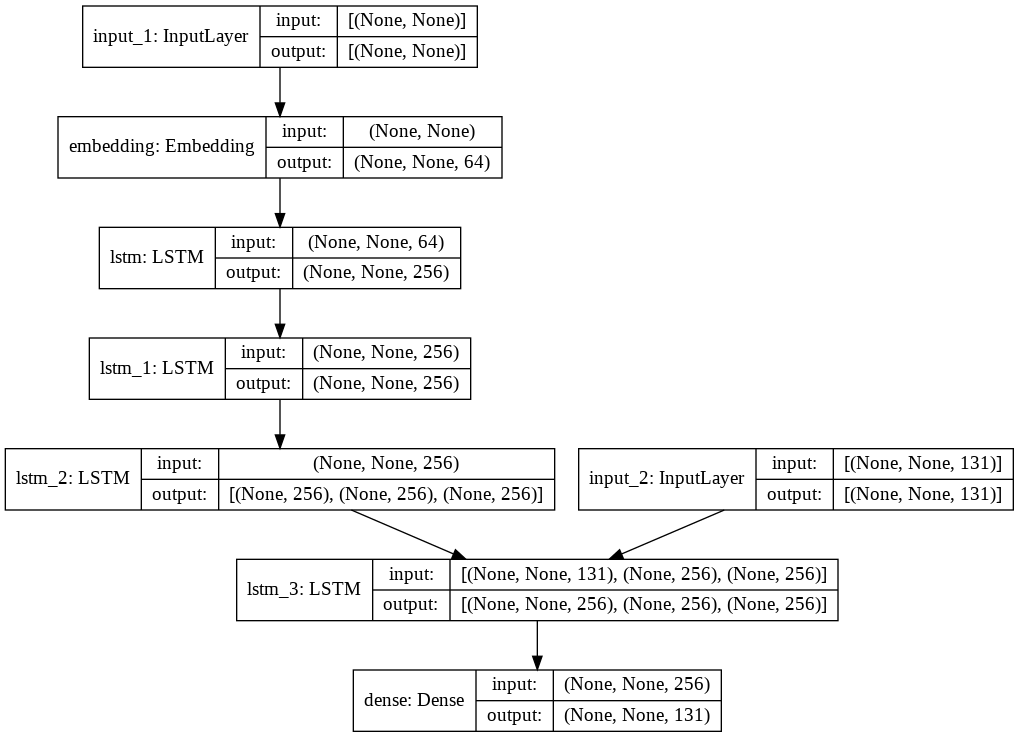

In [ ]:
best_model.summary()
plot_model(best_model, show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          1728      
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         328704    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 1,381,056
Trainable params: 1,381,056
Non-trainable params: 0
_________________________________________________________________


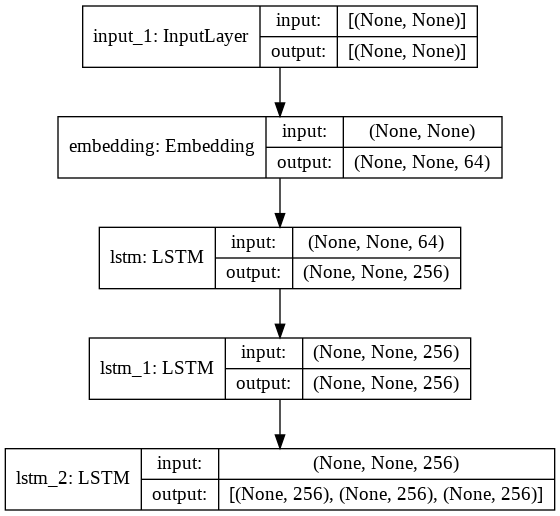

In [ ]:
best_encoder_model.summary()
plot_model(best_encoder_model, show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 131)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  397312      input_2[0][0]                    
                                                                 input_3[0][0]              

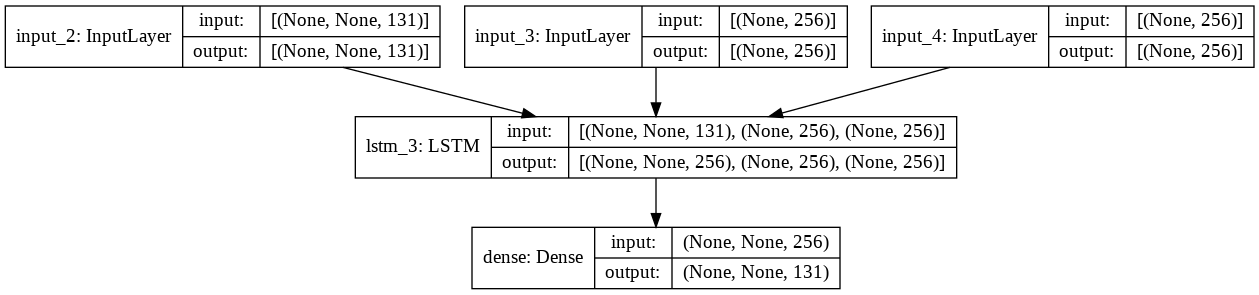

In [ ]:
best_decoder_model.summary()
plot_model(best_decoder_model, show_shapes=True)

In [ ]:
def test(X_test,Y_test,encoder_model,decoder_model):
    X_test_integer_encoded = encode_docs(X_test,english_alpha2index)
    predicted_words = []

    for input_seq in X_test_integer_encoded:
    
        input_seq = input_seq.reshape(1,25)
    
        states_value = encoder_model.predict(input_seq)

        target_seq = np.zeros((1,1, len(hindi_alpha2index)))
        target_seq[0,0, hindi_alpha2index["\t"]] = 1.0

        decoded_word = ""
        while True:
            output_tokens, *states = decoder_model.predict([target_seq] + [states_value])

            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            sampled_char = hindi_index2alpha[sampled_token_index]
        
            if sampled_char == "\n" or len(decoded_word) > 25:
                break

            decoded_word += sampled_char

            target_seq = np.zeros((1, 1,len(hindi_alpha2index)))
            target_seq[0, 0, sampled_token_index] = 1.0

            states_value = [states[i] for i in range(len(states))]

        predicted_words.append(decoded_word)

    correct = 0

    for y,y_predicted in zip(Y_test,predicted_words):
        if y == y_predicted:
            correct += 1
    
    accuracy = (correct/len(predicted_words))*100

    (pd.DataFrame({'English Word': X_test, 'True Transliteration': Y_test, 'Predicted Transliteration': predicted_words})
   .to_csv('results.csv', index=False))
  
    return accuracy


In [ ]:
test_acuraccy = test(x_raw_test,y_raw_test,best_encoder_model,best_decoder_model)


In [ ]:
print("the test accuracy is",test_acuraccy)

the test accuracy is 28.80941803642825


In [ ]:
best_model.save("/content/drive/MyDrive/bestModel")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bestModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bestModel/assets


##Displaying Some Test Results

In [2]:
df = pd.read_csv('results.csv')

In [25]:
def color(row):
    if row["Predicted Transliteration"] == row["True Transliteration"]:
        return pd.Series('color: green',row.index)
    else:
        return pd.Series('color: red', row.index)
    

In [33]:
df.sample(n = 50).style.apply(color,axis = 1)

,English Word,True Transliteration,Predicted Transliteration
2575,faisala,फ़ैसला,फ़ैसा
411,ilaj,इलाज,इलाज
1896,deonar,देवनार,डेनोर
2626,phogat,फोगाट,फोगत
2846,beast,बीस्ट,बीस्ट
3188,munshiganj,मुंशीगंज,मूंसंजाग
1132,charts,चार्ट्स,चार्टस
1385,jeevant,जीवंत,जीवंत
1118,chanwal,चांवल,चंवाल
4399,swikarte,स्वीकारते,शिवृत्स


In [8]:
display(df.sample(n=50))

,English Word,True Transliteration,Predicted Transliteration
3688,wanshwad,वंशवाद,वंशवाद
4432,haldi,हल्दी,जल्डी
2957,bharne,भरने,भरने
2944,bhabhoot,भभूत,भौभूत
4143,sagrika,सागरिका,सगरीक
4344,stops,स्टॉप्स,सटोस
2030,navjaagaran,नवजागरण,नवजारण
3361,registerd,रजिस्टर्ड,रजिस्टर्स
3331,yarayan,यात्राएं,यार्यन
4067,submit,सबमिट,सबमीत
